## Victorian Era Authorship Attribution

This notebook follows on from [this](https://github.com/chriskward/stylometry-toolkit/blob/main/authorship-attribution.ipynb) notebook demonstrating an Authorship Attribution classifier using a SVM
and [stylometry-toolkit](https://github.com/chriskward/stylometry-toolkit/tree/main) to vectorise text as relative frequencies of character n-grams.

Whilst that approach was, with this dataset, quite successful, that is not always the case with real world, un-curated datasets. However, for a simple demonstration, we will use the same dataset again and build a simple classifier using the **MarkovModel** class in this repository. As before, I would recommend running this notebook in Google Colab.

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd drive/MyDrive/Colab Notebooks/markov-language-model
sys.path.append('/content/drive/MyDrive/Colab Notebooks/markov-language-model')

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/markov-language-model


In [ ]:
import numpy as np
import pandas as pd
from markovmodel import MarkovModel
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay, f1_score

In [ ]:
data = pd.read_csv('victorian-authors.csv')
data.head() , data.tail()

(                                                text  author
 0  ou have time to listen i will give you the ent...       1
 1  wish for solitude he was twenty years of age a...       1
 2  and the skirt blew in perfect freedom about th...       1
 3  of san and the rows of shops opposite impresse...       1
 4  an hour s walk was as tiresome as three in a s...       1,
                                                     text  author
 17820  a sudden flash of lightning he could not at on...      15
 17821  not leave her room and at the end of the week ...      15
 17822  happened after she left them dry your eyes the...      15
 17823  again no doubt mrs forest said turning to mrs ...      15
 17824  well i hope we shall be able to conquer death ...      15)

We will randomly select 4 authors out of the fifteen present and create a balanced dataset of managable size by sampling 250 text samples from each of the four selected authors.

In [ ]:
no_of_authors = 4

# randomly sample required number of authors
author_list = data['author'].sample(no_of_authors, replace=False).values

# extract the texts by these randomly chosen authors
bool_mask = data['author'].isin(author_list)
data = data[bool_mask]
data.head(), data.tail()

(                                                   text  author
 1507  in her lips that were parted just then in a of...       4
 1508  as her unwelcome by the fa te of coach fellow ...       4
 1509  but i never told you what the accident was he ...       4
 1510  through the gray smoke of his he had as from s...       4
 1511  and moved away so rapidly that s why my dear b...       4,
                                                     text  author
 17820  a sudden flash of lightning he could not at on...      15
 17821  not leave her room and at the end of the week ...      15
 17822  happened after she left them dry your eyes the...      15
 17823  again no doubt mrs forest said turning to mrs ...      15
 17824  well i hope we shall be able to conquer death ...      15)

In [ ]:
# how many examples per class (the dataset is not balanced)
counts = data['author'].value_counts()
counts

8     6914
4     1483
15    1460
9     1108
Name: author, dtype: int64

In [ ]:
# find the class smallest number of texts

no_to_sample = 250
#no_to_sample = counts.min()
sampled_list = []

# sample this number of texts from each
# author to ensure a balanced dataset
for i in counts.index:
  sampled_list.append( (data[ data['author'] == i]).sample(no_to_sample) )

data = pd.concat(sampled_list)
data.head(), data.tail()

(                                                   text  author
 7207  in that tr ring hour oh none for words have na...       8
 8728  y and ami tâ and apparently beat expectations ...       8
 3987  mr and mrs for we will â ha â we will certainl...       8
 3866  if the sun ever touched it it was but with a r...       8
 8202  have felt for a a thick curtain had fallen on ...       8,
                                                     text  author
 10620  shouted gaily and offered him a piece of bear ...       9
 10838  tor it it was not there he shook them it did n...       9
 10840  it together she took out the letter with a i a...       9
 10319  with a sharp and pleasing effect this ended th...       9
 10652  the said the cur right humbly doth the parish ...       9)

In [ ]:
x_train, x_test, y_train, y_test = tts(data['text'], data['author'], test_size=0.2)

# combining the data & label for the training set
# simplifies the extraction of the text into a single
# string for each author in the cell below

train_data = pd.concat((x_train,y_train), axis = 1)

For brevity, we can use scikit-learn's train_test_split function to randomly sample a test set of 50 samples per author. However, the MarkovMovel class expects training data in the form of a single string, so for each author we concatenate each training text.

A model is trained for each author and these are stored in model_list

In [ ]:
# model parameters

n = 10
alpha = 0.001

model_list = []

for author in train_data['author'].unique():
  training_string = str()

  for text in train_data[ train_data['author'] == author]['text']:
    training_string += ' ' + text + ' '

model_list.append( MarkovModel(training_string, n, alpha) )


Predictions are obtained by passing each test set sample to each models .predict() method. This returns a log-probability score. We classify the test sample to the author whos model returned the greatest log-probability.

In [ ]:
y_hat = []

for test_string in x_test:
  log_probs = []

  # for each text sample in the test set obtain the
  # log probability score returned by each model

  for model in model_list:
    log_probs.append( model.predict(test_string) )

  log_probs = np.array(log_probs)
  prediction_arg = log_probs.argmax()

  # the arg_max gives us the index position of the 'winning'
  # model in model_list. We want the actual author label. This
  # is the value at the corresponding position in counts.index

  y_hat.append( counts.index[ prediction_arg ] )

In [ ]:
print (f'Accuracy {f1_score(y_hat, y_test, average="micro")}' )
print (f'Macro F1 {f1_score(y_hat, y_test, average="macro")}' )

Accuracy 0.945
Macro F1 0.9432734900758155


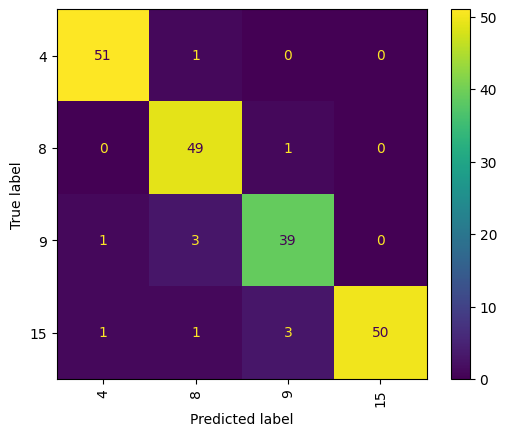

In [ ]:
labels = np.sort( y_test.unique() )
confusion_plot = ConfusionMatrixDisplay( confusion_matrix(y_test, y_hat), display_labels = labels)
confusion_plot.plot(xticks_rotation=90);

The [SVM classifier](https://github.com/chriskward/stylometry-toolkit/blob/main/authorship-attribution.ipynb) reported an accuracy of 89% over the test set. It should be pointed out that this is not a like-for-like comparison, we randomly sampled for authors in both cases so we are testing both methodologies using different data. However, it is notable that this **MarkovModel** exhibited over ninety percent accuracy on this classification task and required no complex feature engineering.